# LimberJack Target Practice

## Model

In [10]:
] activate "../../Glamdring/MicroCanonicalHMC.jl"

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl`


In [11]:
using LinearAlgebra
using Turing
using GaussianProcess
using LimberJack
using DataFrames
using CSV
using YAML
using NPZ
using PythonCall
sacc = pyimport("sacc");

using Plots

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [12]:
fid_cosmo = Cosmology()
n = 11
N = 101
latent_x = range(0., stop=3., length=n)
x = range(0., stop=3., length=N)

0.0:0.03:3.0

In [16]:
sacc_path = "/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path = "/home/jaimerz/PhD/LimberJack.jl/data/DESY1/DESY1.yml"
sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)
DES_meta, DES_files = make_data(sacc_file, yaml_file)

cls_data = DES_meta.data
cls_cov = DES_meta.cov

fs8_meta = npzread("/home/jaimerz/PhD/LimberJack.jl/data/fs8s/fs8s.npz")
fs8_zs = fs8_meta["z"]
fs8_data = fs8_meta["data"]
fs8_cov = fs8_meta["cov"]

cov = zeros(Float64, length(fs8_data)+length(cls_data), length(fs8_data)+length(cls_data))
cov[1:length(fs8_data), 1:length(fs8_data)] = fs8_cov
cov[length(fs8_data)+1:(length(fs8_data)+length(cls_data)),
        length(fs8_data)+1:(length(fs8_data)+length(cls_data))] = cls_cov
data = [fs8_data ; cls_data];

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESwl__0 5
DESgc__0 DESwl__1 5
DESgc__0 DESwl__2 5
DESgc__0 DESwl__3 5
DESgc__1 DESwl__0 8
DESgc__1 DESwl__1 8
DESgc__1 DESwl__2 8
DESgc__1 DESwl__3 8
DESgc__2 DESwl__0 10
DESgc__2 DESwl__1 10
DESgc__2 DESwl__2 10
DESgc__2 DESwl__3 10
DESgc__3 DESwl__0 11
DESgc__3 DESwl__1 11
DESgc__3 DESwl__2 11
DESgc__3 DESwl__3 11
DESgc__4 DESwl__0 13
DESgc__4 DESwl__1 13
DESgc__4 DESwl__2 13
DESgc__4 DESwl__3 13
DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24


In [17]:
@model function DES_gp_model(data)
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb ~ Uniform(0.028, 0.065)
    h ~ TruncatedNormal(72, 5, 0.64, 0.82)
    s8 ~ Uniform(0.4, 1.2)
    ns ~ Uniform(0.84, 1.1)

    DESgc__0_b ~ Uniform(0.8, 3.0)
    DESgc__1_b ~ Uniform(0.8, 3.0)
    DESgc__2_b ~ Uniform(0.8, 3.0)
    DESgc__3_b ~ Uniform(0.8, 3.0)
    DESgc__4_b ~ Uniform(0.8, 3.0)
    DESgc__0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__1_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__2_dz ~ TruncatedNormal(0.0, 0.006, -0.2, 0.2)
    DESgc__3_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESgc__4_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESwl__0_dz ~ TruncatedNormal(-0.001, 0.016, -0.2, 0.2)
    DESwl__1_dz ~ TruncatedNormal(-0.019, 0.013, -0.2, 0.2)
    DESwl__2_dz ~ TruncatedNormal(0.009, 0.011, -0.2, 0.2)
    DESwl__3_dz ~ TruncatedNormal(-0.018, 0.022, -0.2, 0.2)
    DESwl__0_m ~ Normal(0.012, 0.023)
    DESwl__1_m ~ Normal(0.012, 0.023)
    DESwl__2_m ~ Normal(0.012, 0.023)
    DESwl__3_m ~ Normal(0.012, 0.023)
    A_IA ~ Uniform(-5, 5) 
    alpha_IA ~ Uniform(-5, 5)

    nuisances = Dict("DESgc__0_b" => DESgc__0_b,
                     "DESgc__1_b" => DESgc__1_b,
                     "DESgc__2_b" => DESgc__2_b,
                     "DESgc__3_b" => DESgc__3_b,
                     "DESgc__4_b" => DESgc__4_b,
                     "DESgc__0_dz" => DESgc__0_dz,
                     "DESgc__1_dz" => DESgc__1_dz,
                     "DESgc__2_dz" => DESgc__2_dz,
                     "DESgc__3_dz" => DESgc__3_dz,
                     "DESgc__4_dz" => DESgc__4_dz,
                     "DESwl__0_dz" => DESwl__0_dz,
                     "DESwl__1_dz" => DESwl__1_dz,
                     "DESwl__2_dz" => DESwl__2_dz,
                     "DESwl__3_dz" => DESwl__3_dz,
                     "DESwl__0_m" => DESwl__0_m,
                     "DESwl__1_m" => DESwl__1_m,
                     "DESwl__2_m" => DESwl__2_m,
                     "DESwl__3_m" => DESwl__3_m,
                     "A_IA" => A_IA,
                     "alpha_IA" => alpha_IA)
    
    eta = 0.2
    l = 0.3
    v ~ filldist(truncated(Normal(0, 1), -3, 3), n)
    
    mu = fid_cosmo.Dz(vec(latent_x))
    K = sqexp_cov_fn(latent_x; eta=eta, l=l)
    latent_gp = latent_GP(mu, v, K)
    gp = conditional(latent_x, x, latent_gp, sqexp_cov_fn;
                      eta=1.0, l=l)
    
    cosmology = Cosmology(Ωm, Ωb, h, ns, s8,
                          tk_mode="EisHu",
                          Pk_mode="Halofit", 
                          custom_Dz=[x, gp])

    cls = Theory(cosmology, DES_meta, DES_files; Nuisances=nuisances)
    fs8s = fs8(cosmology, fs8_zs)
    theory = [fs8s; cls]
    
    data ~ MvNormal(theory, cov)
end

DES_gp_model (generic function with 2 methods)

In [18]:
DES_model_cond = DES_gp_model(data)
DES_target = TuringTarget(DES_model_cond);

## Sampling

In [19]:
DES_precond = [0.25172500083748506, 0.07615331840979878, 0.37013779031128646, 
    0.3843438188676137, 0.66814760350777, 0.8815675051765066,
    0.9394373992565151, 0.8754431458494949, 1.0579197741114286, 
    1.1360573907868132, 0.05074804177049421, 0.04576895785968372, 
    0.040605876361027006, 0.0698845598057394, 0.06847370659245473, 
    0.1073231095323539, 0.08204992978227615, 0.07646449193174346, 
    0.14333612007022253, 0.18312865481644083, 0.1591611428637791,
    0.14871287866734334, 0.17758496819457525, 1.4368354719127692, 15.568989342724386];

In [20]:
DES_spl = MCHMC(0.07, sqrt(36); sigma=ones(36));

In [21]:
samples= Sample(DES_spl, DES_target, 10;
                burn_in=200, file_name=string("samples_", 1), dialog=true)

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅
[ Info: Starting burn in


LoadError: DomainError with 0.0:
integrand produced Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}}(NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN) in the interval (0.0, 0.0)

In [ ]:
s8s = [sample[5] for sample in samples]
Wms = [sample[1] for sample in samples]
#plot(s8s, label="s8")
plot(Wms, label="Wm")

In [ ]:
histogram2d(Wms, s8s, bins=(60,60), show_empty_bins=true,
            ranges = [[0.2, 0.4],[0.6, 1.2]], normalize=:pdf)

In [ ]:
E = [sample[end-1] for sample in samples[200:end]]#
std(E)^2/21

In [39]:

std(Wms)

0.01272682209991546

In [40]:
b1s = [sample[6] for sample in samples[200:end]]
std(b1s)

0.20614423563229425

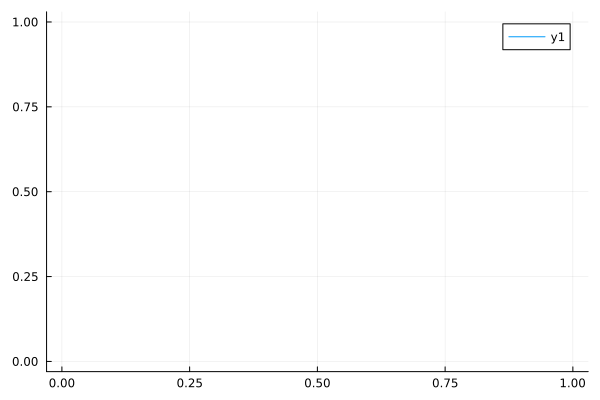

In [15]:
plot(Wms)

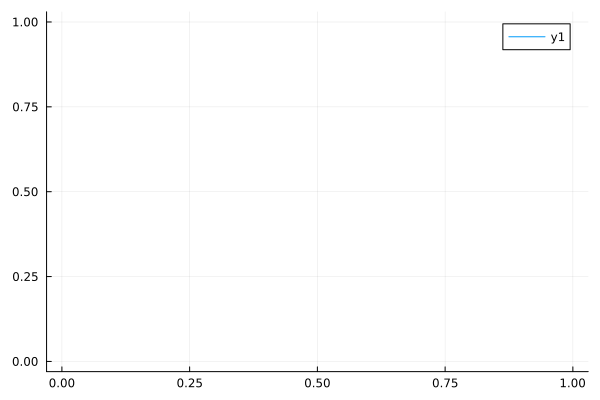

In [16]:
plot(b1s)

In [52]:
sigma = std(samples[250:1001])[1:end-2]

25-element Vector{Float64}:
 0.02955068536535341
 0.012067773602538403
 0.029934282647348584
 0.05686867204619623
 0.061697028754043974
 0.13068565245771951
 0.1442136349185697
 0.13642617666313198
 0.16866044248835593
 0.18823178869575813
 0.005635832270982163
 0.00401300921710752
 0.0030154559051012867
 0.007451034442112501
 0.011558649660224823
 0.009483716980426797
 0.008428681571452134
 0.01068023280013815
 0.046553975697859004
 0.014836095470138809
 0.011973914069191368
 0.01858972928606238
 0.017240121405785996
 0.17409931077687282
 1.0757022970158552

In [23]:
samples = sample(stat_model, spl, 1000; dialog=true)

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅


LoadError: DomainError with 0.0:
integrand produced Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}}(NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN) in the interval (0.0, 0.0)

## NUTS

In [39]:
samples_hmc = sample(stat_model, NUTS(100, 0.65),
                     300, progress=true; save_state=true)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling:   4%|█▍                                       |  ETA: 0:02:26┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████████████████| Time: 1:14:57


Chains MCMC chain (300×25×1 Array{Float64, 3}):

Iterations        = 101:1:400
Number of chains  = 1
Samples per chain = 300
Wall duration     = 4502.67 seconds
Compute duration  = 4502.67 seconds
parameters        = Ωm, Ωb, h, s8, ns, DECALS__0_b, DECALS__1_b, DECALS__2_b, DECALS__3_b, DECALS__0_dz, DECALS__1_dz, DECALS__2_dz, DECALS__3_dz
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse        ess      rhat   ⋯
        Symbol   Float64   Float64    Float64   Float64    Float64   Float64   ⋯

            Ωm    0.2811    0.0226     0.0013    0.0024    98.0312    1.0213   ⋯
            Ωb    0.0402    0.0069     0.0004    0.0005   144.1265    1.0020   ⋯
             h    0.7376    0.0470     0.0027    0.0050   105.2713    1.0019   ⋯
            s8    0.9177   

In [15]:
summary_hmc.ess

25-element Vector{Float64}:
  107.13649180104869
  331.4835789816811
  207.484061400768
  111.64048654758332
  600.4013034569028
  114.39496059843647
  117.33719647252566
  114.56966849849671
  111.15547545924896
  105.06968640469209
  961.3377488207435
  700.0507524844818
  837.2166448905194
  682.3676139298411
  566.0490257440192
  837.5008331222044
  733.9973963424983
  549.1048795030388
  792.5424251430129
 1009.6818545217956
  763.2299996132994
  872.0250289709837
  763.7811879280131
  552.5319549420313
  731.942598764305

In [16]:
Wms_hmc = vec(samples_hmc[!, "Ωm"])
s8s_hmc = vec(samples_hmc[!, "s8"]);

In [17]:
Wm_hmc_ker = ash(Wms_hmc; m=30)
s8_hmc_ker = ash(s8s_hmc; m=30)
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30);

LoadError: UndefVarError: `Wms_mchmc` not defined

In [18]:
Plots.plot(Wm_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(Wm_hmc_ker; hist=false, label="HMC", xlabel="Wm")

LoadError: UndefVarError: `Wm_mchmc_ker` not defined

In [19]:
Plots.plot(s8_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(s8_hmc_ker; hist=false, label="HMC",  xlabel="s8")

LoadError: UndefVarError: `s8_mchmc_ker` not defined

## Self-tuning

In [20]:
mchmc = Sampler()
println(string("L = ", mchmc.settings.L, ", eps = ", mchmc.settings.eps))
# This should start self-tuning    

LoadError: UndefVarError: `Sampler` not defined

In [21]:
mchmc.settings.tune_samples

LoadError: UndefVarError: `mchmc` not defined

In [22]:
samples = Sample(mchmc, target; num_steps=10000, dialog=true);

LoadError: UndefVarError: `Sample` not defined